Examples of how one extra feature allows to effectively use KMeans on unusual data:  
https://juanitorduz.github.io/spectral_clustering/ - See the Final Remarks section

In [45]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import itertools
import itertools
import math
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import tsfresh.feature_extraction.feature_calculators as fc
# https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.manifold import TSNE
%matplotlib inline
#%matplotlib notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# 'DTC, us/ft', 'DTS, US/F' are dropped later, and DTC = 'DTC, us/ft' / 'DTS, US/F' is introduced
corr_features = ['DENSITY, g/cm3', 'RDEEP, ohm.m', 'DTC, us/ft', 'DTS, US/F', 'GR, gAPI', 'NEUTRON, CFCF',
                 'NMR_FF, v/v', 'NMR_TPOR, v/v']

df = pd.read_csv('./data/norphlet_original.csv', encoding='utf8')
print(df.shape)
df[corr_features].isna().sum()

(15956, 23)


DENSITY, g/cm3     373
RDEEP, ohm.m        21
DTC, us/ft         619
DTS, US/F          750
GR, gAPI            92
NEUTRON, CFCF      419
NMR_FF, v/v       1562
NMR_TPOR, v/v     1562
dtype: int64

In [3]:
df = df.dropna(subset=corr_features)
df = df.reset_index(drop=True)

df['DT'] = df['DTC, us/ft'] / df['DTS, US/F']
corr_features.append('DT')
corr_features = [item for item in corr_features if item not in ['DTC, us/ft', 'DTS, US/F']]

print(df.shape)
df[corr_features].isna().sum()

(14273, 24)


DENSITY, g/cm3    0
RDEEP, ohm.m      0
GR, gAPI          0
NEUTRON, CFCF     0
NMR_FF, v/v       0
NMR_TPOR, v/v     0
DT                0
dtype: int64

In [4]:
print(df.shape)
df.head()

(14273, 24)


,Well name,Field,Field part,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft",Filename,wellName_old,datasetName,"RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT
0,MC348-3ST1,Appomattox,NE,25654.00,3.1089,66.67333,100.4266,2.0,26.304100,0.251625,0.00265,0.01018,0.001510,0.01434,0.293561,25215.80,17884.80,25140.80,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.424346,NaN,0.663901
1,MC348-3ST1,Appomattox,NE,25654.25,3.1126,66.94559,100.8265,2.0,23.341801,0.222850,0.00308,0.02210,0.002170,0.02735,0.365731,25216.02,17885.02,25141.02,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.416532,NaN,0.663968
2,MC348-3ST1,Appomattox,NE,25654.50,3.0757,67.21785,101.2297,2.0,21.169090,0.203550,0.00337,0.01907,0.002365,0.02481,0.512044,25216.24,17885.24,25141.24,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.253025,NaN,0.664013
3,MC348-3ST1,Appomattox,NE,25654.75,3.0079,67.48043,102.2180,2.0,20.145300,0.187125,0.00467,0.01142,0.003945,0.02004,0.681784,25216.46,17885.46,25141.46,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.145016,NaN,0.660162
4,MC348-3ST1,Appomattox,NE,25655.00,2.9167,67.74301,103.2258,2.0,18.498600,0.173575,0.01121,0.01380,0.012790,0.03780,0.827608,25216.68,17885.68,25141.68,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.094094,NaN,0.656260


In [5]:
# DATA POINTS PER WELL
print('Data points per well after removing missing values:')
for well in df['Well name'].unique():
    print('\t{}: {} datapoints'.format(well, df[df['Well name'] == well].shape[0]))

Data points per well after removing missing values:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 3679 datapoints
	MC525-2: 1173 datapoints
	MC612-1BP1: 2175 datapoints


In [6]:
# OIL = 2, WATER = 1
df['FLD, unitless'].value_counts()

2.0    12516
1.0     1757
Name: FLD, unitless, dtype: int64

In [7]:
# DATA POINTS PER WELL IN OIL
print('Data points per well after removing missing values that occur in oil:')
for well in df['Well name'].unique():
    print('\t{}: {} datapoints'.format(well, df[(df['Well name'] == well) & (df['FLD, unitless'] == 2)].shape[0]))

Data points per well after removing missing values that occur in oil:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 2709 datapoints
	MC525-2: 874 datapoints
	MC612-1BP1: 1687 datapoints


#### Only the last three wells have water

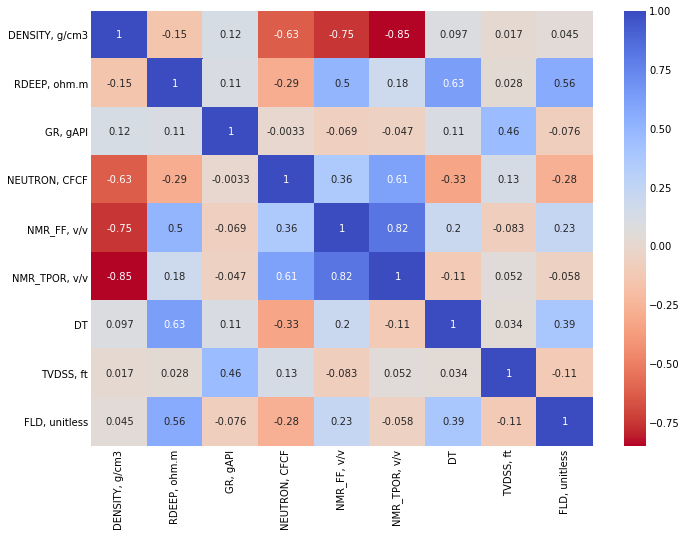

In [8]:
plt.figure(figsize=(10,8))
c = df[corr_features + ['TVDSS, ft', 'FLD, unitless']].corr(method ='spearman')    #pearson, kendall, spearman
sns.heatmap(c, cmap='coolwarm_r', annot=True)

In [9]:
print('Min depth:', df['TVDSS, ft'].min())
print('Max depth:', df['TVDSS, ft'].max())
print('Difference:', math.ceil(df['TVDSS, ft'].max() - df['TVDSS, ft'].min()))

Min depth: 24320.04
Max depth: 28559.0401761094
Difference: 4240


In [10]:
# ZERO DUPLICATES
df[df[corr_features].duplicated()]

,Well name,Field,Field part,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft",Filename,wellName_old,datasetName,"RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT


In [11]:
# KEEP THE ORIGINAL DATA
df_original = deepcopy(df)

In [12]:
to_stay = ['Well name', 'Field', 'Field part', 'MD, ft', 'FLD, unitless', 'Filename', 'wellName_old', 'datasetName',
          'TVD, ft', 'TVDBML, ft', 'TVDSS, ft',  ]
to_scale = [col for col in df.columns if col not in to_stay]

scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

In [13]:
df_original.describe()

,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft","RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT
count,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14249.000000,14273.000000,14273.000000,3899.000000,7330.000000,14273.000000
mean,26173.766896,2.257738,88.286644,150.883623,1.876900,33.679270,0.268774,0.055986,0.009714,0.155509,0.221209,0.325711,25589.165267,18219.939894,25510.567524,-0.009490,0.387352,0.587206
std,956.401021,0.072493,6.667169,14.942749,0.328563,5.831928,0.038503,0.025743,0.010559,0.050017,0.040708,0.496396,1140.328829,1110.746860,1130.774351,0.404960,0.536337,0.031779
min,24515.500000,2.070800,59.988460,96.756100,1.000000,12.798500,0.110347,0.002650,0.000000,0.001152,0.014340,-0.844847,24398.360000,16949.040000,24320.040000,-0.805655,-0.786274,0.510565
25%,25596.250000,2.208708,83.957300,140.160600,2.000000,29.930010,0.248536,0.038649,0.001395,0.119026,0.195283,-0.019315,24880.450000,17507.640000,24804.350000,-0.258043,-0.061483,0.561798
50%,25947.750000,2.256796,88.066930,151.326900,2.000000,33.322400,0.274023,0.050357,0.006341,0.158618,0.220415,0.387888,25253.000000,17931.910000,25181.750000,-0.033886,0.492984,0.585129
75%,26404.386719,2.300160,92.978150,160.722900,2.000000,37.010960,0.296207,0.066569,0.014580,0.193405,0.250058,0.672914,25658.360000,18350.490000,25590.100000,0.289896,0.782214,0.609425
max,28694.603041,3.112600,104.732800,192.824000,2.000000,114.353900,0.385244,0.163572,0.077707,0.295275,0.339213,1.478986,28661.040176,21187.040176,28559.040176,1.424346,1.505512,0.824567


In [14]:
df.describe()

,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft","RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT
count,14273.000000,1.427300e+04,1.427300e+04,1.427300e+04,14273.000000,1.427300e+04,1.427300e+04,1.427300e+04,1.427300e+04,1.427300e+04,1.427300e+04,14273.000000,14249.000000,14273.000000,14273.000000,3.899000e+03,7.330000e+03,1.427300e+04
mean,26173.766896,2.150595e-15,1.593034e-17,3.385196e-16,1.876900,3.345370e-16,3.026764e-16,-1.911640e-16,4.779101e-17,-6.372134e-17,5.416314e-16,0.000000,25589.165267,18219.939894,25510.567524,-5.831590e-17,6.203920e-17,-1.656755e-15
std,956.401021,1.000035e+00,1.000035e+00,1.000035e+00,0.328563,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1140.328829,1110.746860,1130.774351,1.000128e+00,1.000068e+00,1.000035e+00
min,24515.500000,-2.578804e+00,-4.244557e+00,-3.622454e+00,1.000000,-3.580549e+00,-4.114855e+00,-2.071938e+00,-9.200501e-01,-3.086214e+00,-5.081897e+00,-2.358196,24398.360000,16949.040000,24320.040000,-1.966286e+00,-2.188375e+00,-2.411781e+00
25%,25596.250000,-6.763703e-01,-6.493755e-01,-7.176322e-01,2.000000,-6.429076e-01,-5.256562e-01,-6.734721e-01,-7.878916e-01,-7.294452e-01,-6.368916e-01,-0.695087,24880.450000,17507.640000,24804.350000,-6.138517e-01,-8.369092e-01,-7.995363e-01
50%,25947.750000,-1.299887e-02,-3.295578e-02,2.966609e-02,2.000000,-6.119455e-02,1.363206e-01,-2.186550e-01,-3.194832e-01,6.216687e-02,-1.949717e-02,0.125261,25253.000000,17931.910000,25181.750000,-6.025289e-02,1.969639e-01,-6.533816e-02
75%,26404.386719,5.852052e-01,7.036976e-01,6.584881e-01,2.000000,5.713046e-01,7.125082e-01,4.111385e-01,4.608815e-01,7.576820e-01,7.086938e-01,0.699472,25658.360000,18350.490000,25590.100000,7.393924e-01,7.362711e-01,6.992023e-01
max,28694.603041,1.179277e+01,2.466824e+00,2.806836e+00,2.000000,1.383375e+01,3.025076e+00,4.179407e+00,6.439811e+00,2.794469e+00,2.898863e+00,2.323378,28661.040176,21187.040176,28559.040176,3.541137e+00,2.084952e+00,7.469450e+00


In [15]:
[i for i in corr_features if i not in to_scale]

[]

## Additional features

In [16]:
# preliminary estimation of the optimal size of a depth bin
print('Preliminary estimation\n')
for well in df['Well name'].unique():
        
    temp = df[df['Well name'] == well]
    num = temp.shape[0]
    print('\t{}: {} datapoints'.format(well, num))
    
    interval = 5                                               # num of feet in an interval
    mini = temp['TVDSS, ft'].min()
    maxi = temp['TVDSS, ft'].max()
    print('\t\tTVDSS min: {:<8}, max: {:<8}, difference: {:<7} feet'.format(round(mini, 2), round(maxi, 2), round((maxi - mini), 2)))
    print('\t\t{} feet = {:<4} datapoints'.format(interval, round((num/(maxi - mini))*interval, 2)))
    print('\t\tNumber of bins:', round((maxi - mini)/interval, 2))

Preliminary estimation

	MC348-3ST1: 551 datapoints
		TVDSS min: 25140.8 , max: 25261.87, difference: 121.07  feet
		5 feet = 22.76 datapoints
		Number of bins: 24.21
	MC391-1: 2713 datapoints
		TVDSS min: 24755.8 , max: 25309.49, difference: 553.69  feet
		5 feet = 24.5 datapoints
		Number of bins: 110.74
	MC392-1: 950 datapoints
		TVDSS min: 24439.64, max: 24914.13, difference: 474.49  feet
		5 feet = 10.01 datapoints
		Number of bins: 94.9
	MC392-1ST1: 3032 datapoints
		TVDSS min: 25265.89, max: 25819.6 , difference: 553.71  feet
		5 feet = 27.38 datapoints
		Number of bins: 110.74
	MC393-1: 3679 datapoints
		TVDSS min: 24320.04, max: 25005.89, difference: 685.85  feet
		5 feet = 26.82 datapoints
		Number of bins: 137.17
	MC525-2: 1173 datapoints
		TVDSS min: 25065.63, max: 25651.63, difference: 586.0   feet
		5 feet = 10.01 datapoints
		Number of bins: 117.2
	MC612-1BP1: 2175 datapoints
		TVDSS min: 27479.81, max: 28559.04, difference: 1079.23 feet
		5 feet = 10.08 datapoints
		Num

__Well 'MC348-3ST1' has too many data points for 120 feet of depth - look into it (turned out to be fine)__

In [17]:
# statistics for TVDSS (used further)
mini = df['TVDSS, ft'].min()
maxi = df['TVDSS, ft'].max()
print('Total depth span:', maxi - mini)
print('Number of 5-feet bins:', round((maxi - mini)/5, 2))
df['TVDSS, ft'].describe()

Total depth span: 4239.000176109399
Number of 5-feet bins: 847.8


count    14273.000000
mean     25510.567524
std       1130.774351
min      24320.040000
25%      24804.350000
50%      25181.750000
75%      25590.100000
max      28559.040176
Name: TVDSS, ft, dtype: float64

In [18]:
# create depth ranges of 5 feet each, using the min and max TVDSS for the entire dataset
arr_min = np.arange(24320,28559,5).tolist()
arr_max = arr_min[1:]
arr_max.append(28560)
arr_ranges = list(zip(arr_min, arr_max))

In [19]:
# f(x) to find the depth range and its index (which happens to be the array index of the depth range)
def depth_range(v):
    
    matched_range, matched_bin = None, None
    for idx, r in enumerate(arr_ranges):
        if v > r[0] and v <= r[1]:
            matched_range = '-'.join(map(str, r))
            matched_bin   = idx
            break
    
    return matched_range, matched_bin

In [20]:
df[['depth_range', 'depth_bin']] = df['TVDSS, ft'].apply(lambda x: pd.Series(depth_range(x)))

In [21]:
# verify results
df[['Well name','TVDSS, ft','depth_range','depth_bin']].tail(21)

,Well name,"TVDSS, ft",depth_range,depth_bin
14252,MC612-1BP1,28548.317772,28545-28550,845
14253,MC612-1BP1,28548.874601,28545-28550,845
14254,MC612-1BP1,28549.431430,28545-28550,845
14255,MC612-1BP1,28549.880929,28545-28550,845
14256,MC612-1BP1,28550.220914,28550-28555,846
14257,MC612-1BP1,28550.560900,28550-28555,846
14258,MC612-1BP1,28550.900885,28550-28555,846
14259,MC612-1BP1,28551.240871,28550-28555,846
14260,MC612-1BP1,28551.580857,28550-28555,846
14261,MC612-1BP1,28551.920843,28550-28555,846


In [22]:
# how many data points in each depth range in each well
print('Actual distribution of data points by bin\n')
for well in df['Well name'].unique():
        
    temp = df[df['Well name'] == well]
    num = temp.shape[0]
    print('\t{}: {} datapoints'.format(well, num))
    
    interval = 5                                               # num of feet in an interval
    mini = temp['TVDSS, ft'].min()
    maxi = temp['TVDSS, ft'].max()
    print('\t\tTVDSS min: {:<8}, max: {:<8}, difference: {:<7} feet'.format(round(mini, 2), round(maxi, 2), round((maxi - mini), 2)))
    
    num_points = []
    for abin in temp['depth_bin'].unique():
        num_points.append(temp[temp['depth_bin'] == abin].shape[0])
                
    print('\t\tNumber of bins:', len(temp['depth_bin'].unique()))
    print('\t\tAverage of {} datapoints per one 5-feet bin'.format(round(sum(num_points)/len(num_points), 2)))
    print('\t\tComplete distribution by bin:', num_points)
    print('*'*100 + '\n')

Actual distribution of data points by bin

	MC348-3ST1: 551 datapoints
		TVDSS min: 25140.8 , max: 25261.87, difference: 121.07  feet
		Number of bins: 25
		Average of 22.04 datapoints per one 5-feet bin
		Complete distribution by bin: [20, 22, 23, 23, 22, 23, 23, 23, 22, 23, 23, 22, 23, 23, 23, 22, 23, 23, 22, 23, 23, 23, 22, 23, 9]
****************************************************************************************************

	MC391-1: 2713 datapoints
		TVDSS min: 24755.8 , max: 25309.49, difference: 553.69  feet
		Number of bins: 111
		Average of 24.44 datapoints per one 5-feet bin
		Complete distribution by bin: [21, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 25, 24, 25, 24, 25, 24, 25, 24, 25, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 24, 25, 24, 25, 24, 25, 24, 25, 24, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 25, 24, 24, 25, 24, 25, 24, 2

In [23]:
# for the entire dataset
print('For the entire dataset:')
num_points = []
for abin in df['depth_bin'].unique():
    num_points.append(df[df['depth_bin'] == abin].shape[0])

print('\tNumber of bins:', len(df['depth_bin'].unique()))
print('\tAverage of {} datapoints per one 5-feet bin'.format(round(sum(num_points)/len(num_points), 2)))

For the entire dataset:
	Number of bins: 517
	Average of 27.61 datapoints per one 5-feet bin


__This means that not all depth ranges are represented by data points in the dataset - there are gaps (because the total number of depth ranges is 847)!__ Therefore, it may make sense to calculate the additional features in two different way - a) for the entire dataset, b) for each well individually, and then attemp to cluster the two resulting enriched datasets separately

call function from a module using its string name: fc.abs_energy(t) == getattr(fc, 'abs_energy')(t)

In [24]:
# rename df columns for better combination with function calls for additional features
df = df.rename(columns = {'Well name': 'wellname', 'Field':'field', 'Field part':'field_part', 'MD, ft':'md_ft',
                         'DENSITY, g/cm3':'density_g_cm3', 'DTC, us/ft':'dtc_us_ft', 'DTS, US/F':'dts_us_ft',
                         'FLD, unitless':'fluid', 'GR, gAPI':'gr_gapi', 'NEUTRON, CFCF':'neutron_cfcf',
                         'NMR_BW, v/v':'nmr_bw_vv', 'NMR_CBW, v/v':'nmr_cbw_vv', 'NMR_FF, v/v':'nmr_ff_vv',
                         'NMR_TPOR, v/v':'nmr_tpor_vv', 'RDEEP, ohm.m':'rdeep_ohm_m', 'TVD, ft':'tvd_ft',
                         'TVDBML, ft':'tvdbml_ft', 'TVDSS, ft':'tvdss_ft', 'Filename':'filename',
                         'wellName_old':'wellname_old', 'datasetName':'dataset_name', 'RMEDIUM, ohm.m':'rmedium_ohm_m',
                         'RSHALLOW, ohm.m':'rshallow_ohm_m', 'DT':'dt'})

corr_features = ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'nmr_ff_vv', 'nmr_tpor_vv', 'dt']

In [34]:
# separate 'MC612-1BP1', then add it to the beginning
print('       Current size of data:', df.shape)
print('Sise of data for MC612-1BP1:', df[df.wellname == 'MC612-1BP1'].shape)
print(' Rows for ramaining 5 wells:', df.shape[0] - df[df.wellname == 'MC612-1BP1'].shape[0])

       Current size of data: (14273, 26)
Sise of data for MC612-1BP1: (2175, 26)
 Rows for ramaining 5 wells: 12098


In [35]:
# 'MC612-1BP1'
wells_to_stay = ['MC348-3ST1', 'MC391-1', 'MC392-1', 'MC392-1ST1', 'MC393-1', 'MC525-2']
temp = deepcopy(df[df.wellname == 'MC612-1BP1'])
print(temp.shape)

df = df[df.wellname.isin(wells_to_stay)]
print(df.shape)

df = pd.concat([temp, df])
print(df.shape)

df.head()

(2175, 26)
(12098, 26)
(14273, 26)


,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,depth_range,depth_bin
12098,MC612-1BP1,Dover,NaN,27611.099625,5.427742,-3.407274,-2.467338,2.0,-0.425993,-2.723917,-1.286644,-0.146462,-2.024821,-3.339442,0.984989,27581.809549,20107.809549,27479.809549,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.083924,0.996489,-0.380970,27475-27480,631
12099,MC612-1BP1,Dover,NaN,27611.567138,4.333665,-3.150465,-2.290410,2.0,-0.351732,-2.289127,-1.238942,0.169720,-1.825346,-2.982181,1.160290,27582.275294,20108.275294,27480.275294,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.210769,0.965666,-0.329249,27480-27485,632
12100,MC612-1BP1,Dover,NaN,27612.034651,3.748207,-3.032162,-2.005533,2.0,-0.436394,-1.969398,-1.263449,0.293456,-1.595199,-2.682813,1.272828,27582.741039,20108.741039,27480.741039,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.461521,1.025080,-0.762905,27480-27485,632
12101,MC612-1BP1,Dover,NaN,27612.502164,3.569701,-2.750482,-1.801018,2.0,-0.509298,-1.954853,-1.342966,0.270586,-1.341687,-2.427547,1.346535,27583.206784,20109.206784,27481.206784,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.511060,1.036860,-0.722904,27480-27485,632
12102,MC612-1BP1,Dover,NaN,27612.969677,3.525557,-2.451782,-1.721352,2.0,-0.463976,-2.004230,-1.422483,0.247715,-1.088174,-2.172284,1.387113,27583.672529,20109.672529,27481.672529,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.528794,1.048949,-0.391090,27480-27485,632


In [36]:
df = df.reset_index(drop=True)

In [37]:
corr_features

['density_g_cm3',
 'rdeep_ohm_m',
 'gr_gapi',
 'neutron_cfcf',
 'nmr_ff_vv',
 'nmr_tpor_vv',
 'dt']

In [39]:
for col in corr_features:
    df[col + '_sample_entropy'] = np.nan
                
print('Current size of data:', df.shape)

Current size of data: (14273, 33)


In [40]:
for abin in df['depth_bin'].unique():
        
    temp = df[df['depth_bin'] == abin]
    idxs = temp.index
        
    for col in corr_features:
        time_series = temp[col].tolist()        
        res_col = col + '_sample_entropy'    
        res_val = fc.sample_entropy(time_series)
        for idx in idxs:
            df.loc[idx, res_col] = res_val

C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1577: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A / B)
C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1577: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)
C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1577: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)


In [42]:
print(df.shape)
df.head()

(14273, 33)


,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,depth_range,depth_bin,density_g_cm3_sample_entropy,rdeep_ohm_m_sample_entropy,gr_gapi_sample_entropy,neutron_cfcf_sample_entropy,nmr_ff_vv_sample_entropy,nmr_tpor_vv_sample_entropy,dt_sample_entropy
0,MC612-1BP1,Dover,NaN,27611.099625,5.427742,-3.407274,-2.467338,2.0,-0.425993,-2.723917,-1.286644,-0.146462,-2.024821,-3.339442,0.984989,27581.809549,20107.809549,27479.809549,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.083924,0.996489,-0.380970,27475-27480,631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MC612-1BP1,Dover,NaN,27611.567138,4.333665,-3.150465,-2.290410,2.0,-0.351732,-2.289127,-1.238942,0.169720,-1.825346,-2.982181,1.160290,27582.275294,20108.275294,27480.275294,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.210769,0.965666,-0.329249,27480-27485,632,1.386294,0.693147,NaN,1.098612,0.693147,0.693147,NaN
2,MC612-1BP1,Dover,NaN,27612.034651,3.748207,-3.032162,-2.005533,2.0,-0.436394,-1.969398,-1.263449,0.293456,-1.595199,-2.682813,1.272828,27582.741039,20108.741039,27480.741039,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.461521,1.025080,-0.762905,27480-27485,632,1.386294,0.693147,NaN,1.098612,0.693147,0.693147,NaN
3,MC612-1BP1,Dover,NaN,27612.502164,3.569701,-2.750482,-1.801018,2.0,-0.509298,-1.954853,-1.342966,0.270586,-1.341687,-2.427547,1.346535,27583.206784,20109.206784,27481.206784,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.511060,1.036860,-0.722904,27480-27485,632,1.386294,0.693147,NaN,1.098612,0.693147,0.693147,NaN
4,MC612-1BP1,Dover,NaN,27612.969677,3.525557,-2.451782,-1.721352,2.0,-0.463976,-2.004230,-1.422483,0.247715,-1.088174,-2.172284,1.387113,27583.672529,20109.672529,27481.672529,MC612-1BP1 Dover_LQC.csv,MC612-1BP1 Dover,LQC,2.528794,1.048949,-0.391090,27480-27485,632,1.386294,0.693147,NaN,1.098612,0.693147,0.693147,NaN


In [43]:
entropy_cols = [c for c in df.columns if 'entropy' in c]
entropy_cols

['density_g_cm3_sample_entropy',
 'rdeep_ohm_m_sample_entropy',
 'gr_gapi_sample_entropy',
 'neutron_cfcf_sample_entropy',
 'nmr_ff_vv_sample_entropy',
 'nmr_tpor_vv_sample_entropy',
 'dt_sample_entropy']

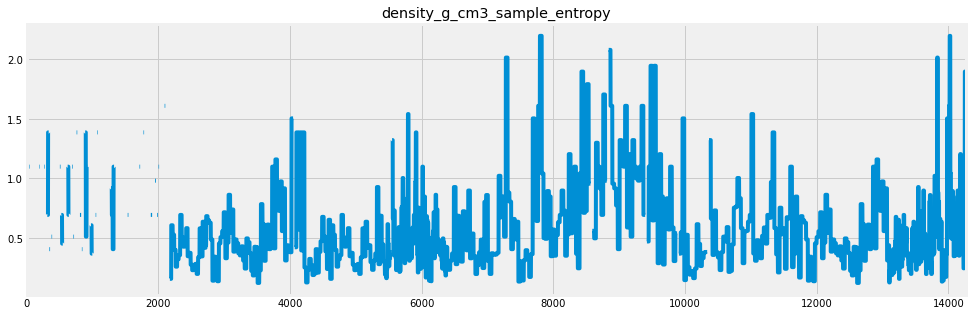

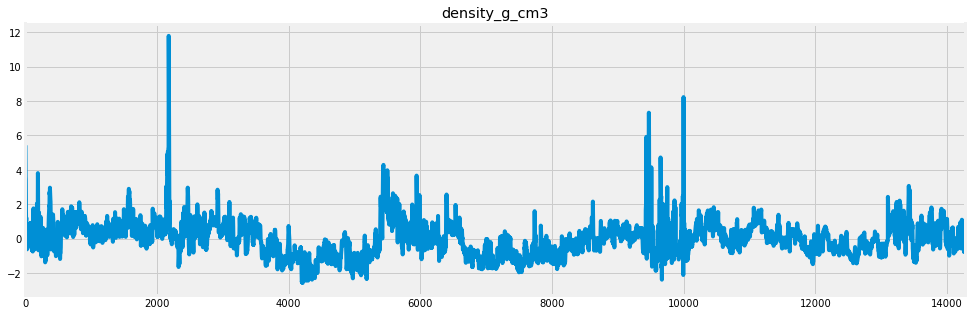

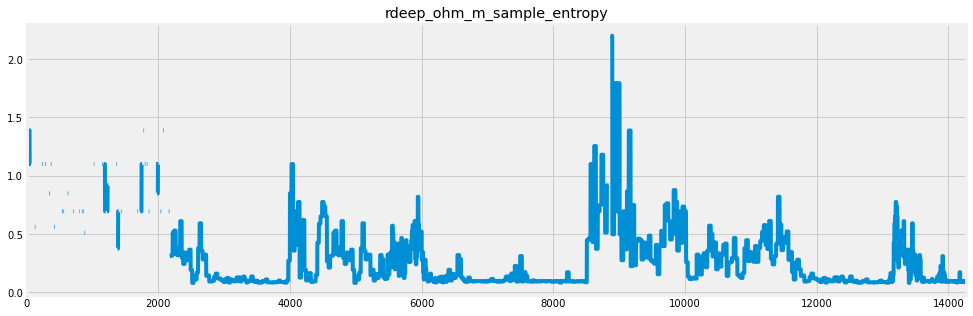

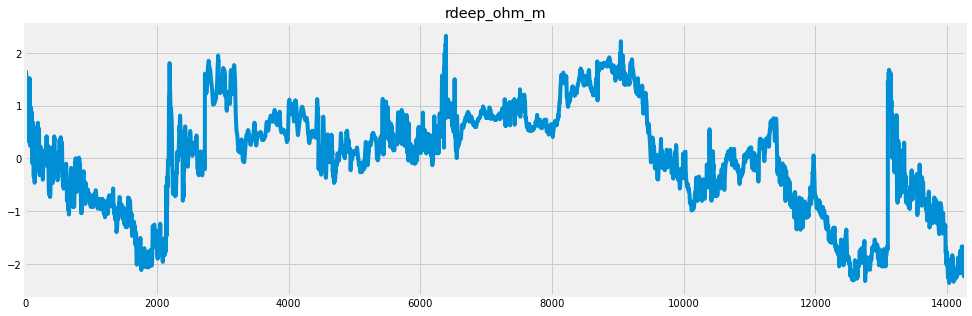

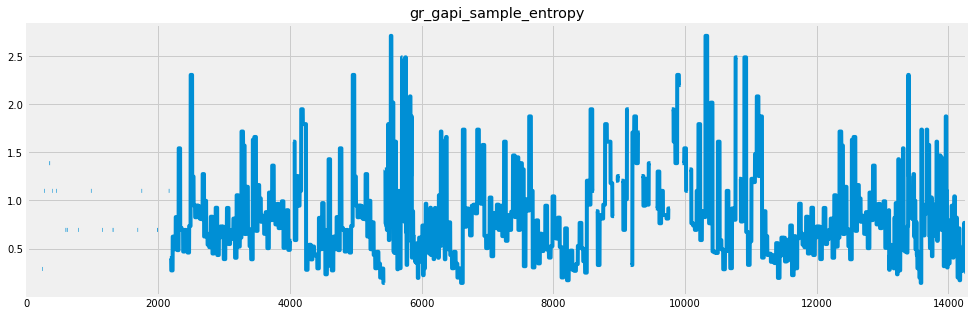

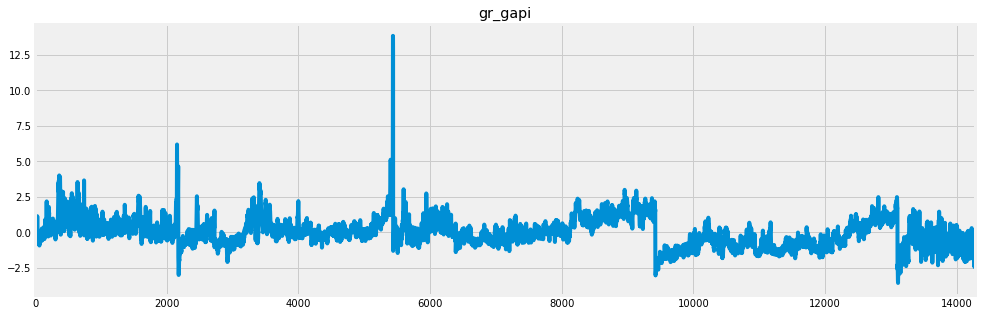

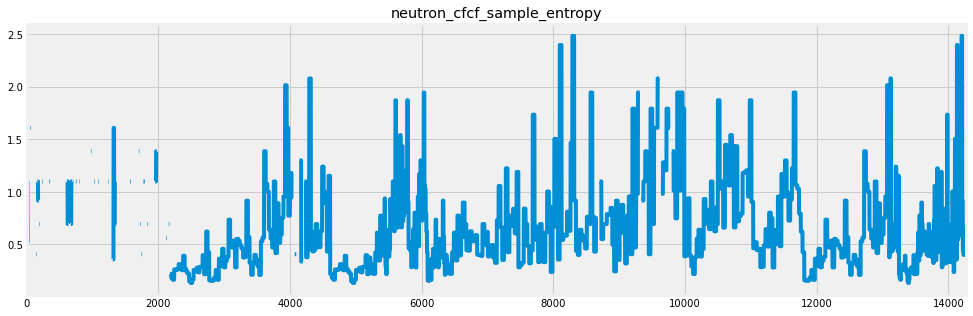

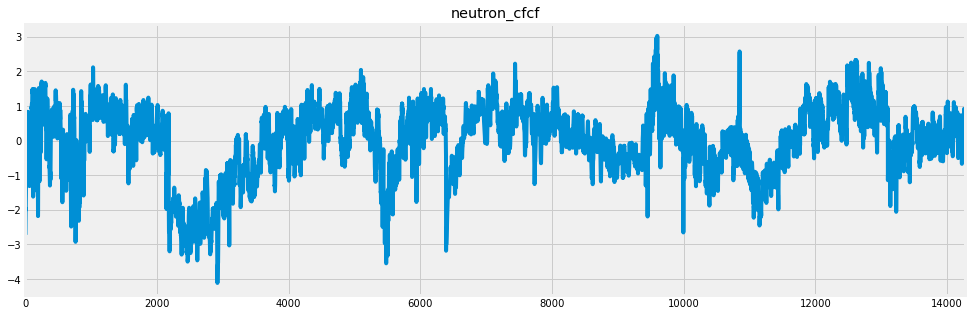

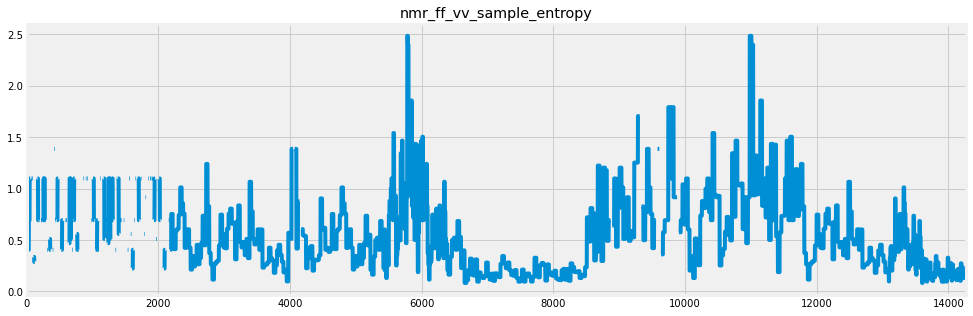

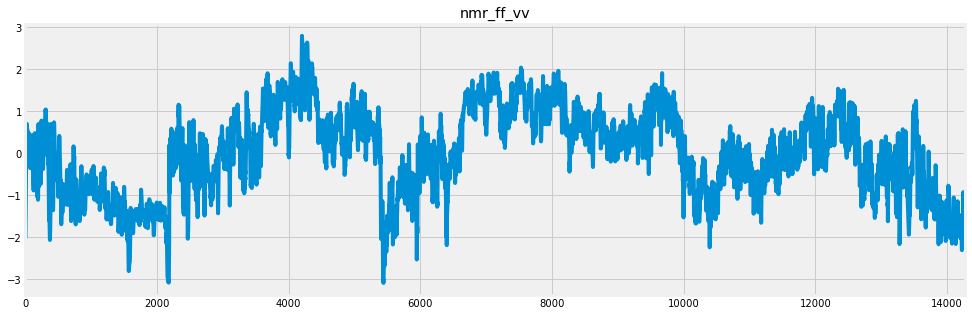

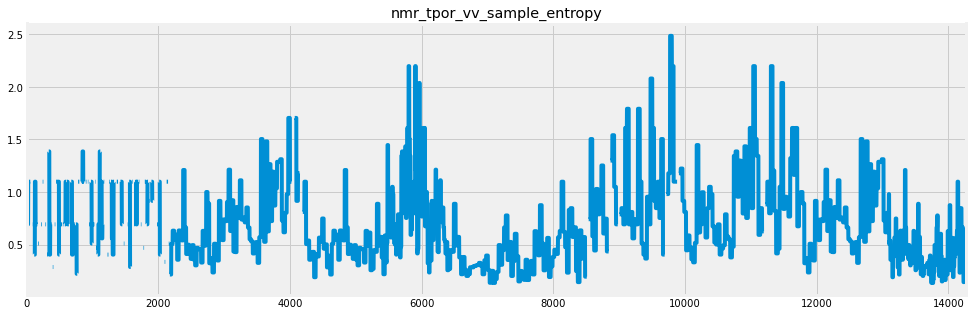

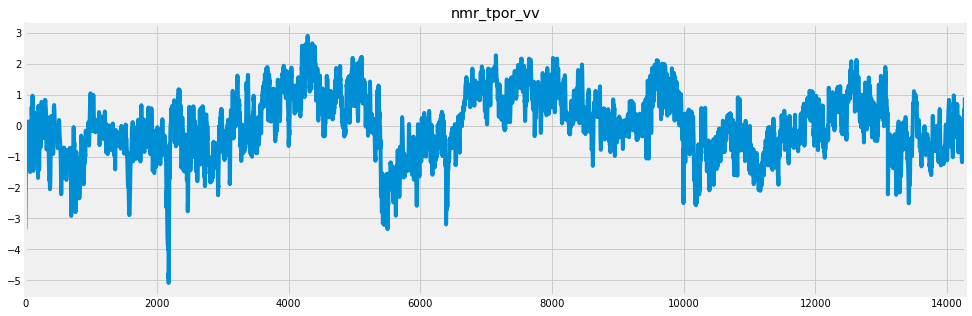

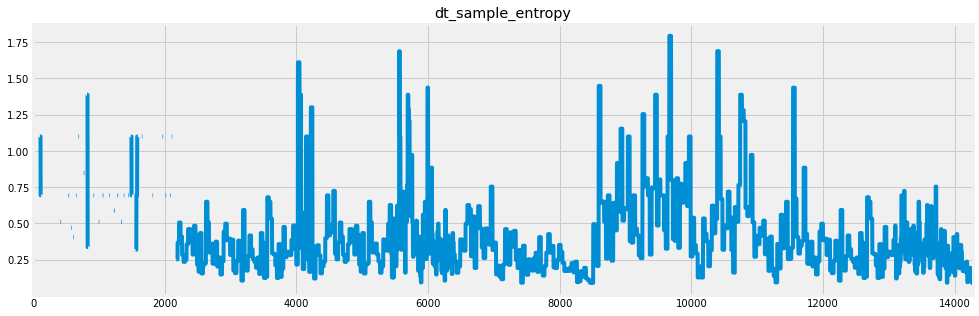

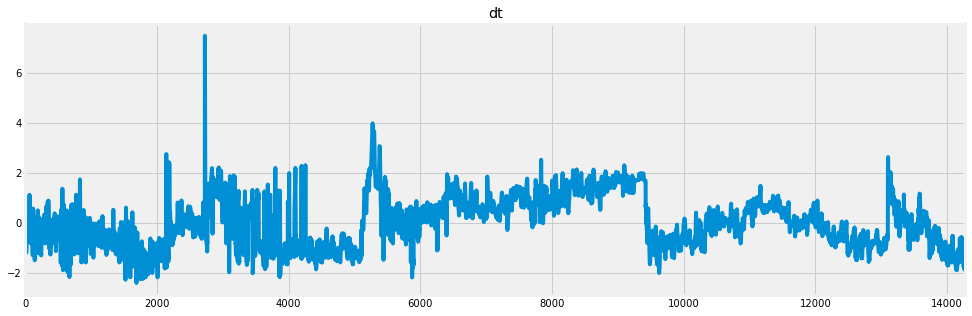

In [46]:
for c in entropy_cols:
    df[c].plot(figsize=(15,5), title=c)
    plt.show()
    temp = c.replace('_sample_entropy', '')
    df[temp].plot(figsize=(15,5), title=temp)
    plt.show()

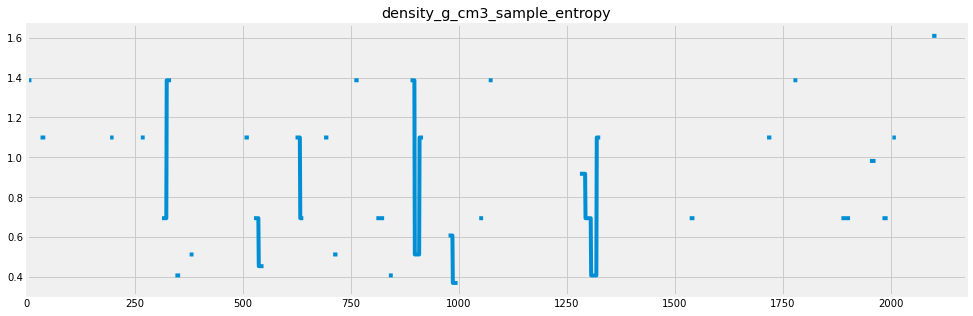

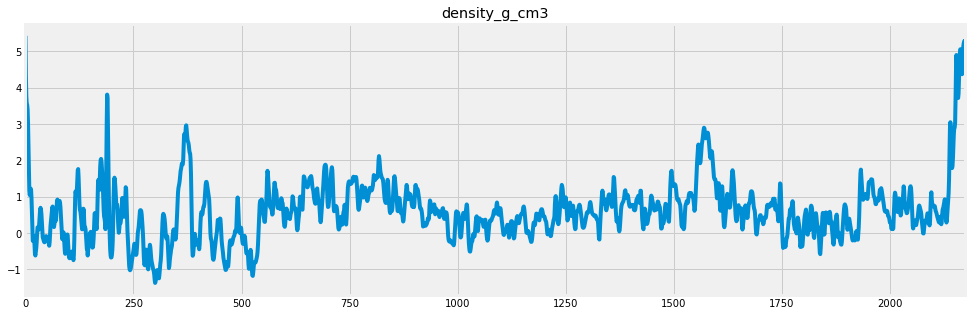

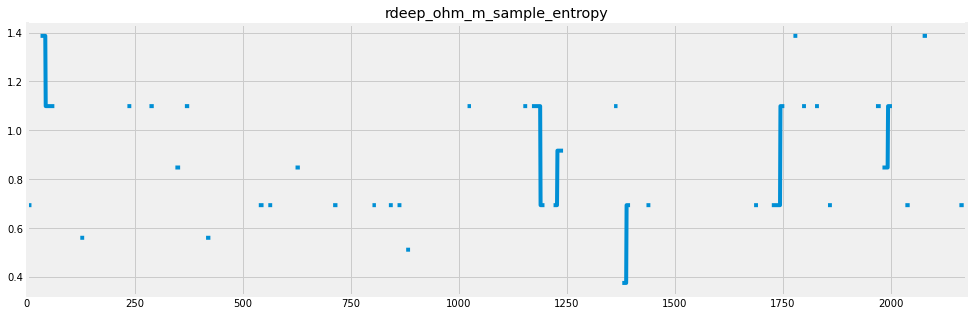

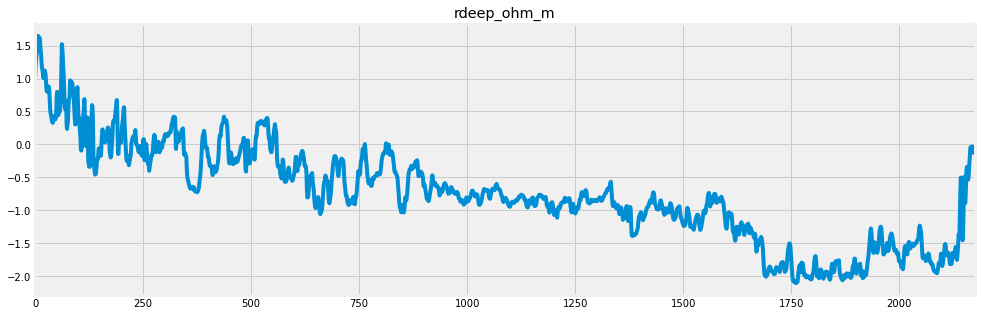

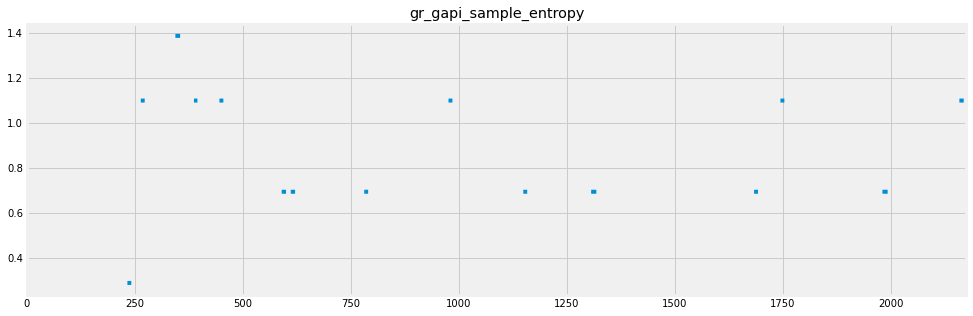

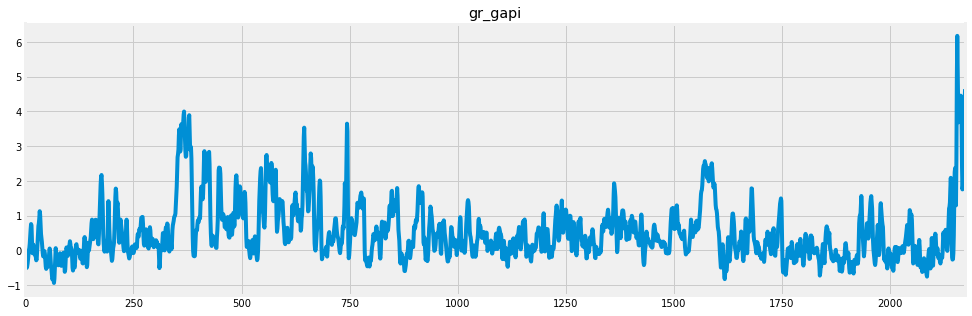

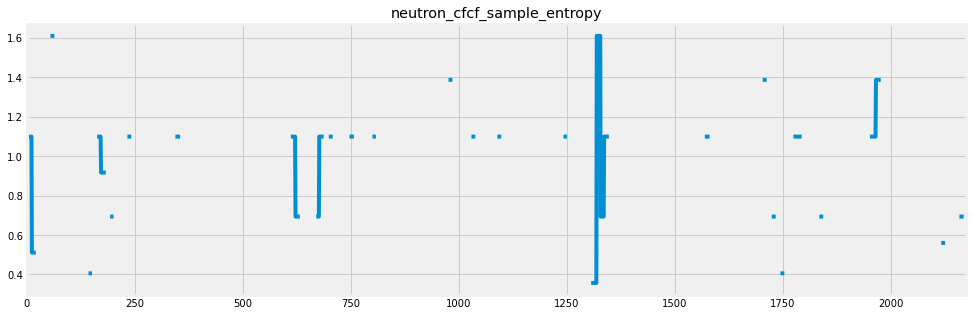

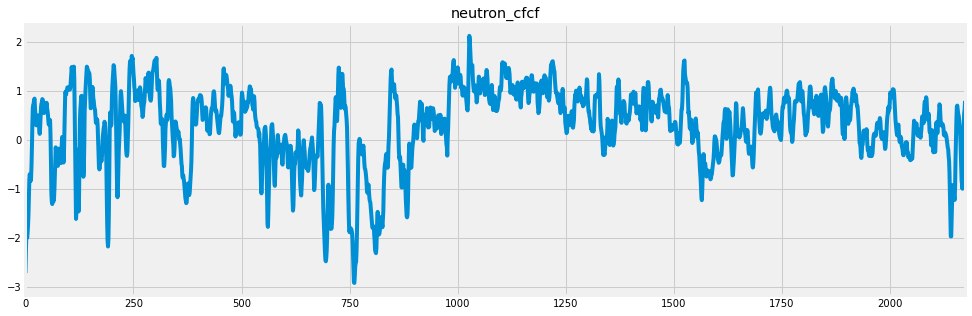

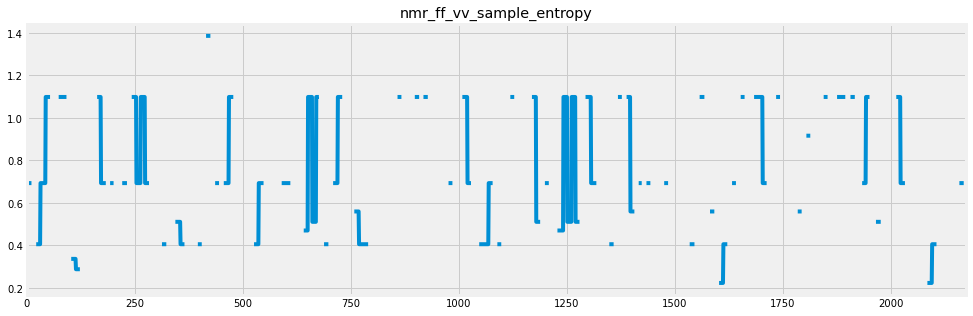

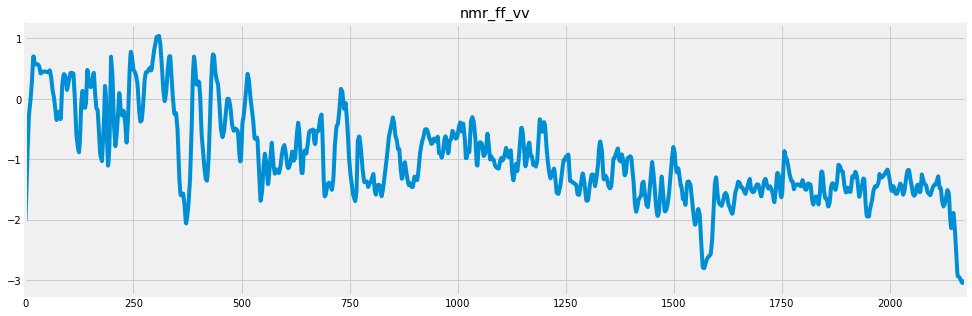

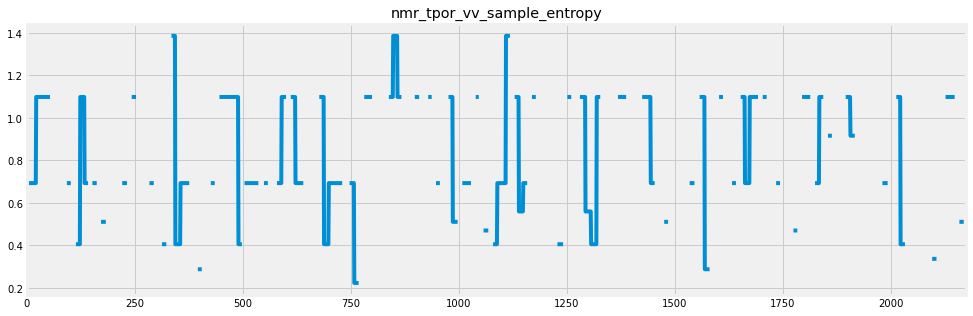

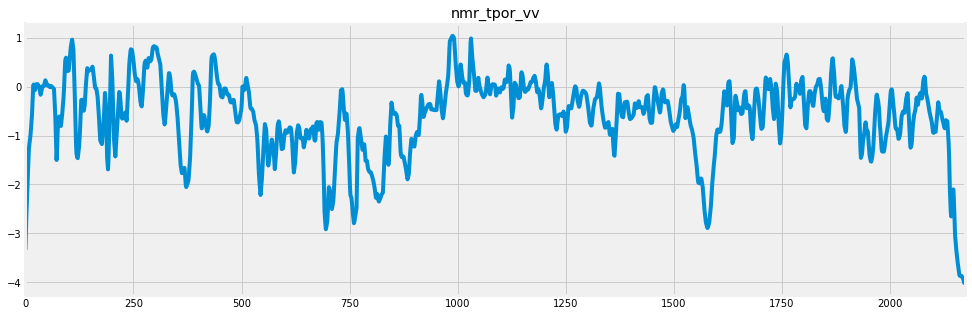

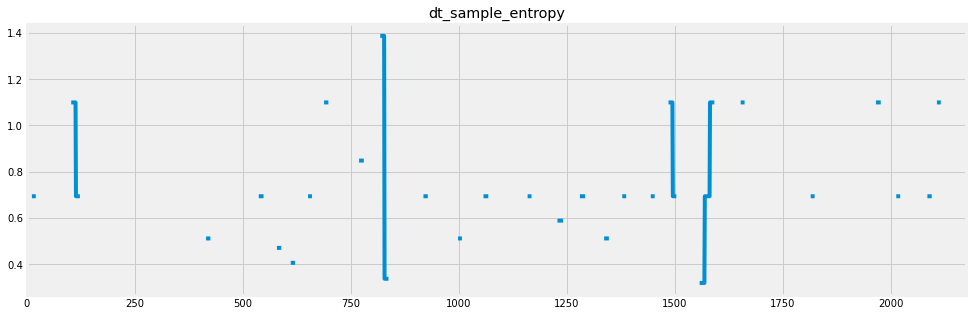

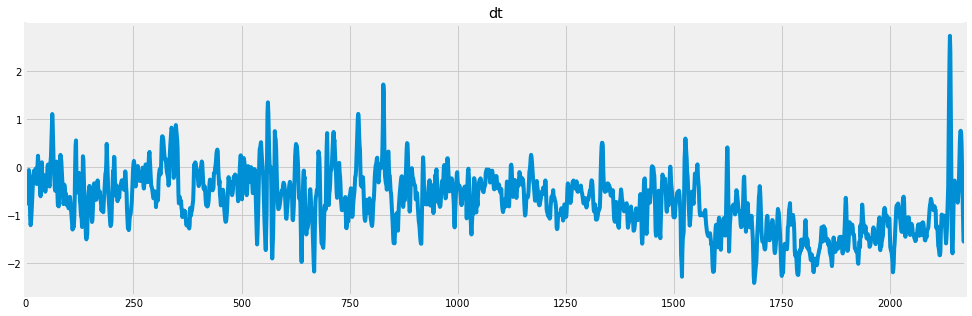

In [47]:
for c in entropy_cols:
    df[df.wellname == 'MC612-1BP1'][c].plot(figsize=(15,5), title=c)
    plt.show()
    temp = c.replace('_sample_entropy', '')
    df[df.wellname == 'MC612-1BP1'][temp].plot(figsize=(15,5), title=temp)
    plt.show()

In [48]:
df.wellname.unique()

array(['MC612-1BP1', 'MC348-3ST1', 'MC391-1', 'MC392-1', 'MC392-1ST1',
       'MC393-1', 'MC525-2'], dtype=object)

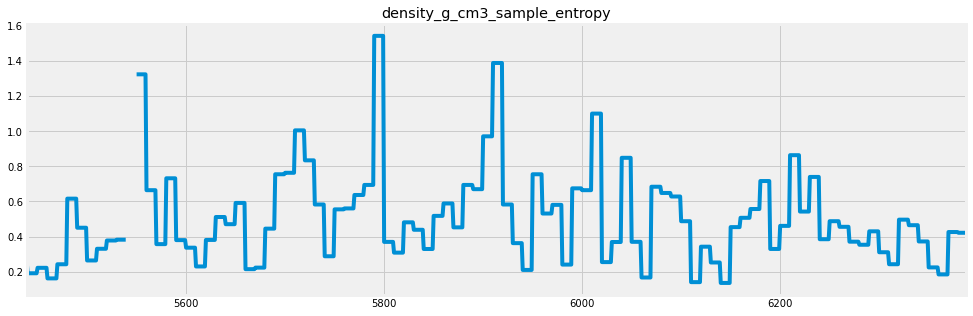

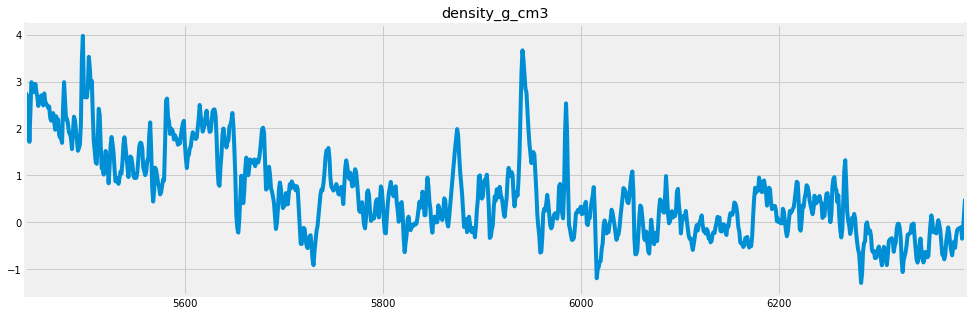

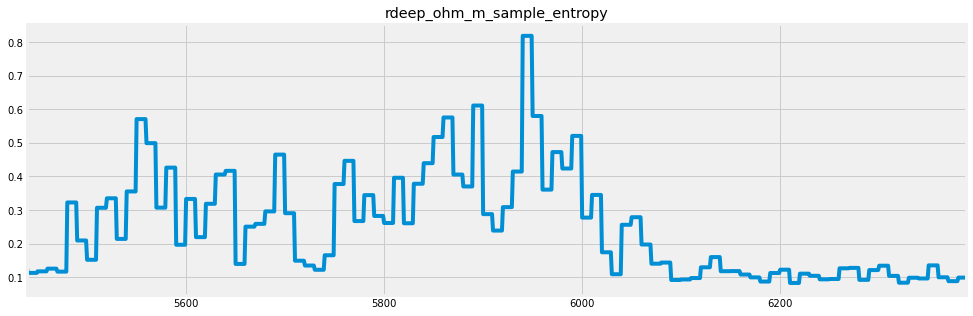

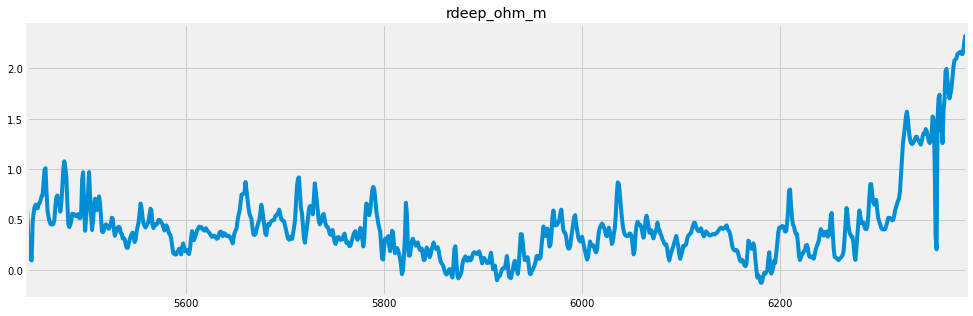

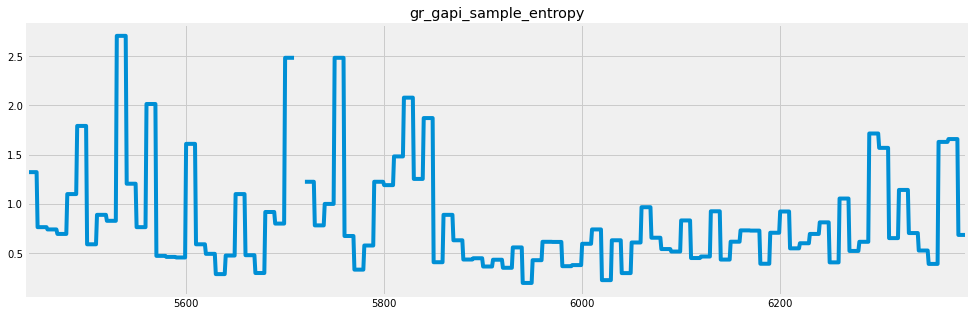

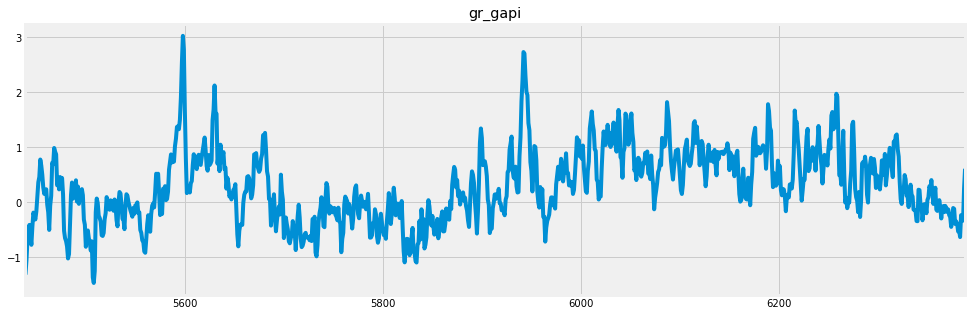

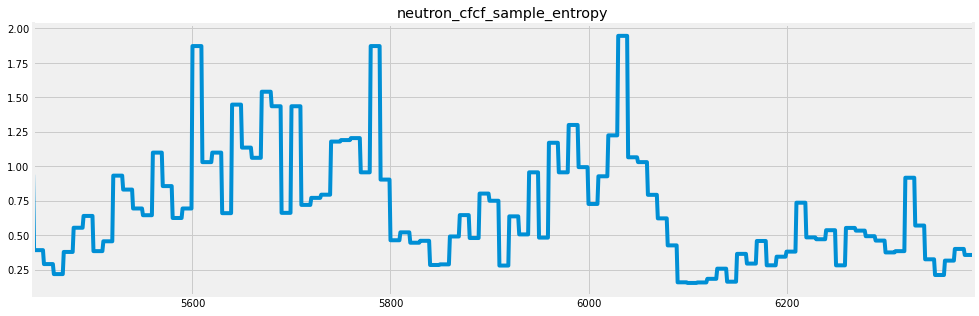

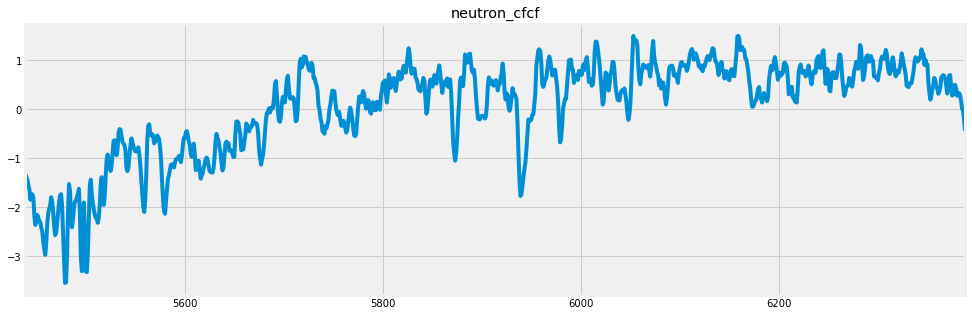

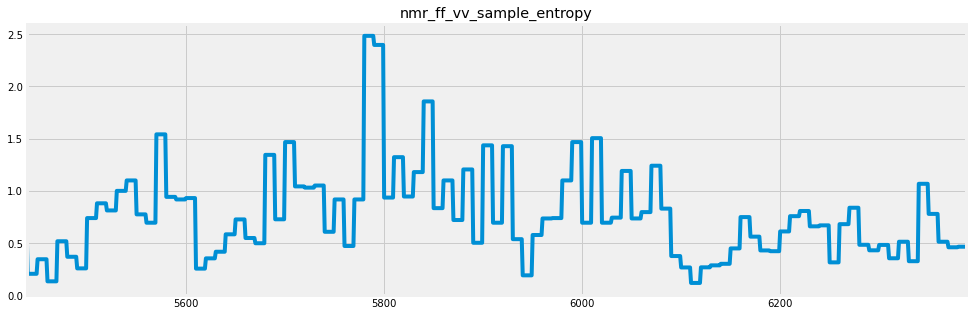

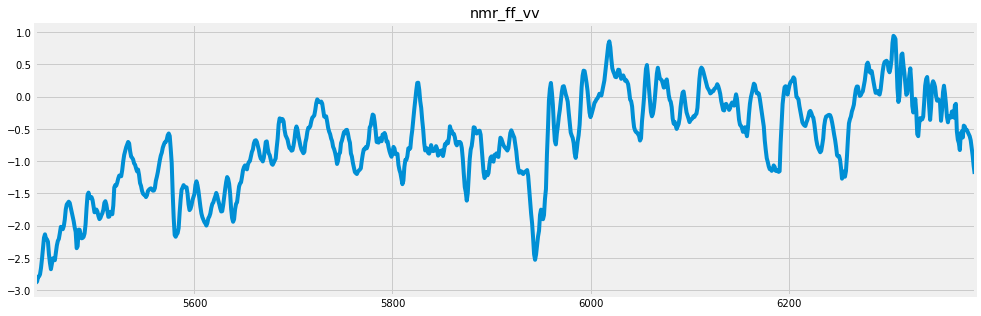

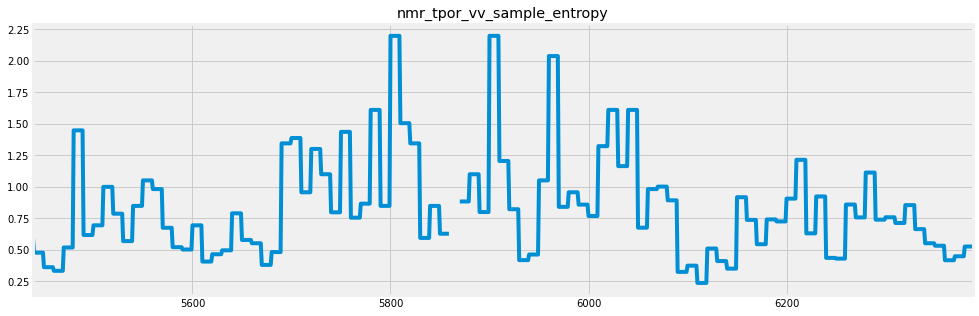

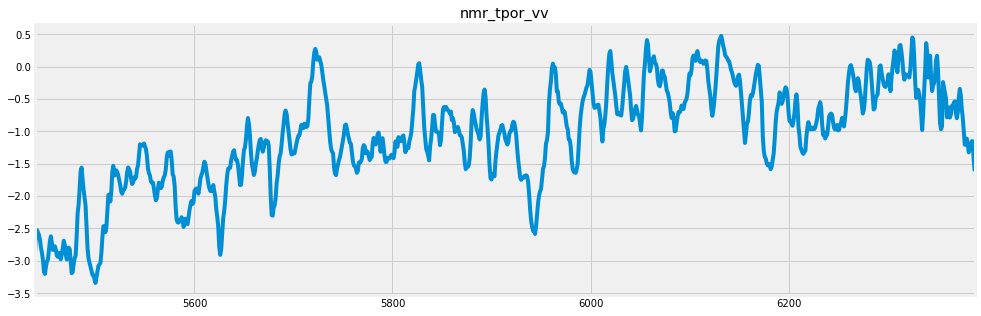

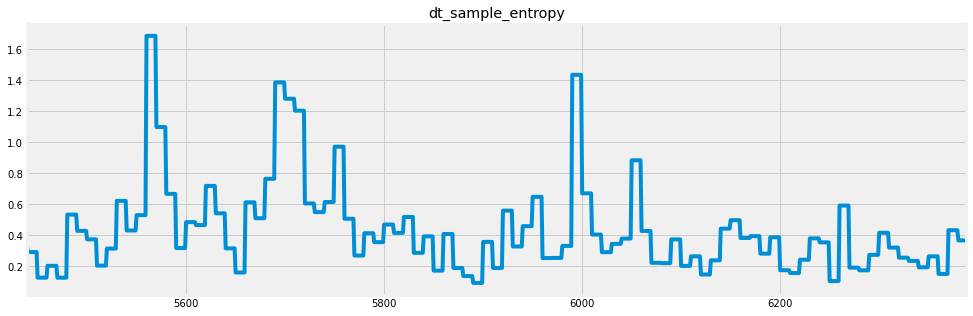

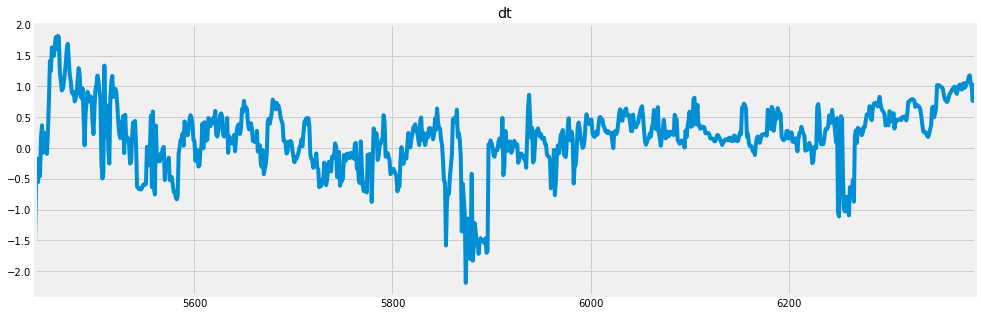

In [51]:
# plot a normal well
well = 'MC392-1'
for c in entropy_cols:
    df[df.wellname == well][c].plot(figsize=(15,5), title=c)
    plt.show()
    temp = c.replace('_sample_entropy', '')
    df[df.wellname == well][temp].plot(figsize=(15,5), title=temp)
    plt.show()